# Plan
- Get line by using cv2 to detect lines and connections between nodes
- nodes will always be in the same locations, ROI will not change
- Find contours is too complex to use, need to simplify to reduce room of errors

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
from utils import preprocess

In [3]:
def canny(img):
    img_canny = cv.Canny(img, 50, 200)

    return img_canny

def blur_and_canny(img):
    blurred = cv.GaussianBlur(img, (7,7), 1)
    canny = cv.Canny(blurred, 120, 255, 1)

    return canny

def crop_image(img: cv.Mat) -> cv.Mat:
    height, width = img.shape

    min_height = int(0.3*height)
    max_height = int(0.85*height)
    min_width = int(0.3*width)

    cropped_image = img[min_height:max_height, min_width:width]

    return cropped_image

def resize_image(img: cv.Mat, width=1280, height=720) -> cv.Mat:
    resized = cv.resize(img, (width, height))
    
    return resized

34


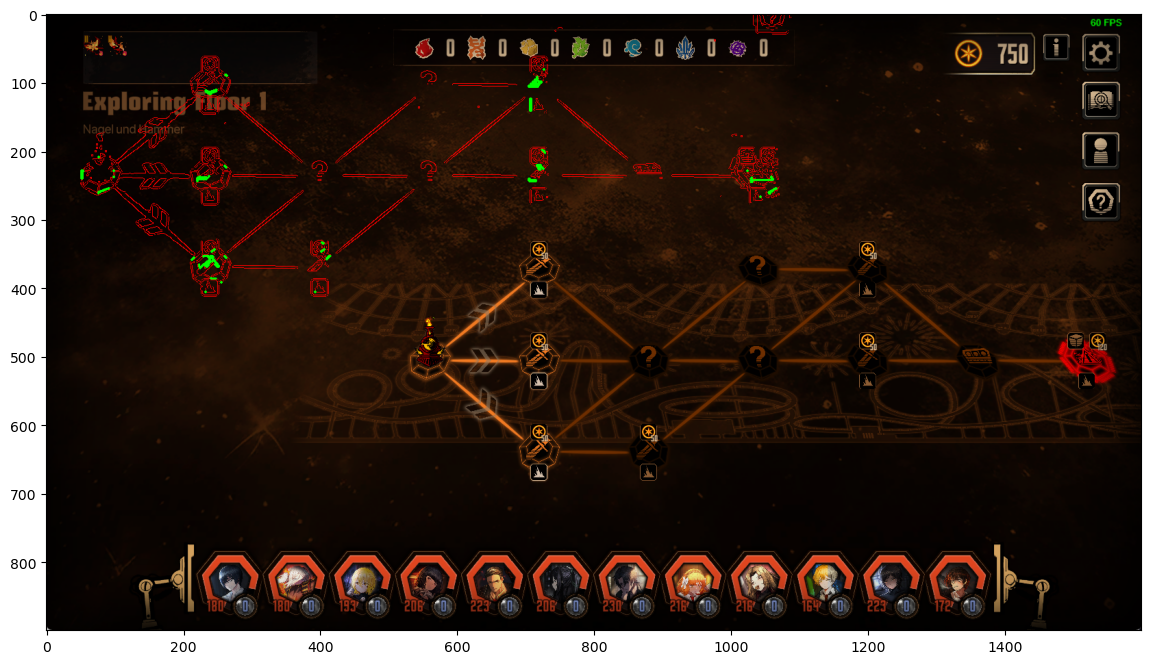

In [4]:
img_original = cv.imread("../images/dungeon2.png")
img_original = cv.cvtColor(img_original, cv.COLOR_BGR2RGB)
img = cv.cvtColor(img_original, cv.COLOR_RGB2GRAY)

img = crop_image(img)
img = preprocess.blur(img, (1,1))
ret, img = cv.threshold(img, 55, 255, cv.THRESH_BINARY)
img = canny(img)
contours, hierarchy = cv.findContours(img, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)

cv.drawContours(img_original, contours, -1, (255,0,0), 1)
approxes = []
for i, cnt in enumerate(contours):
    epsilon = 0.05*cv.arcLength(cnt,True)
    approx = cv.approxPolyDP(cnt,epsilon,True)
    if len(approx) == 3:
        approxes.append(cnt)
        cv.drawContours(img_original, [cnt], 0, (0,255,0), 2)
print(len(approxes))

plt.figure(figsize=(16, 8))
plt.imshow(img_original)

In [5]:
from dataclasses import dataclass

@dataclass
class Nodes():
    nodes: list

@dataclass
class Node():
    name: str
    x: int
    y: int
    connection: Nodes


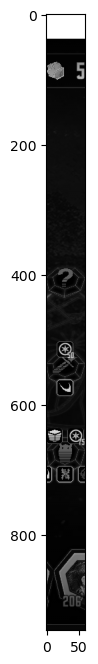

In [6]:
img_original = cv.imread("../images/capture.png")
img_original = cv.cvtColor(img_original, cv.COLOR_BGR2RGB)
img = cv.cvtColor(img_original, cv.COLOR_RGB2GRAY)

img = img[:,700:760]

plt.figure(figsize=(16, 8))
plt.imshow(img, cmap='gray')